In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from pathlib import Path

# Define files to analyze
FILES_TO_ANALYZE = [
    "outputs/ECT/Llama-3.1-8B-Instruct_TriviaMC_ect_results.json",
    "outputs/ECT/Llama-3.1-8B_TriviaMC_ect_results.json",
    "outputs/ECT/Llama-3.1-8B_fs-balanced_TriviaMC_ect_results.json",
    "outputs/ECT/Llama-3.1-8B_fs-random_ZVU_TriviaMC_ect_results.json",
    "outputs/ECT/Llama-3.1-8B_fs-all_answers_Z_TriviaMC_ect_results.json",
    "outputs/ECT/Llama-3.1-8B_fs-none_TriviaMC_ect_results.json",
    "outputs/ECT/Llama-3.1-8B_fs-deceptive_examples_TriviaMC_ect_results.json",
    "outputs/ECT/Llama-3.1-8B-Instruct_adapter-ect_20251222_215412_v0uei7y1_2000_TriviaMC_ect_results.json",
]

In [2]:
def compute_entropy(probs):
    """Compute entropy from probability distribution."""
    probs = np.array(probs)
    # Avoid log(0)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

def analyze_file(filepath):
    """Analyze a single ECT results file."""
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # Extract data for each question
    stated_confidences = []
    mc_entropies = []
    mc_answers = []
    confidence_answers = []
    
    for item in data['data']:
        # Get stated confidence value
        stated_confidences.append(item['stated_confidence_value'])
        
        # Compute entropy from MC probs
        mc_entropy = compute_entropy(item['mc_probs'])
        mc_entropies.append(mc_entropy)
        
        # Get MC answer (predicted_answer)
        mc_answers.append(item['predicted_answer'])
        
        # Get confidence answer (stated_confidence_response)
        confidence_answers.append(item['stated_confidence_response'])
    
    # Invert entropy (low entropy = high confidence)
    inverted_entropies = [-e for e in mc_entropies]
    
    # Compute correlation
    pearson_r, pearson_p = pearsonr(stated_confidences, inverted_entropies)
    spearman_r, spearman_p = spearmanr(stated_confidences, inverted_entropies)
    
    return {
        'stated_confidences': stated_confidences,
        'mc_entropies': mc_entropies,
        'inverted_entropies': inverted_entropies,
        'mc_answers': mc_answers,
        'confidence_answers': confidence_answers,
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'n_questions': len(stated_confidences)
    }

In [3]:
def plot_analysis(filepath, results):
    """Create a comprehensive plot for a single file's analysis."""
    filename = Path(filepath).name
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'ECT Analysis: {filename}', fontsize=14, fontweight='bold')
    
    # 1. Scatter plot: Stated Confidence vs Inverted Entropy
    ax = axes[0, 0]
    ax.scatter(results['stated_confidences'], results['inverted_entropies'], alpha=0.5)
    ax.set_xlabel('Stated Confidence')
    ax.set_ylabel('Inverted MC Entropy (-H)')
    ax.set_title(f"Correlation: Pearson r={results['pearson_r']:.3f} (p={results['pearson_p']:.2e})\n"
                 f"Spearman ρ={results['spearman_r']:.3f} (p={results['spearman_p']:.2e})")
    ax.grid(True, alpha=0.3)
    
    # 2. Distribution of MC Answers
    ax = axes[0, 1]
    from collections import Counter
    mc_counts = Counter(results['mc_answers'])
    options = sorted(mc_counts.keys())
    counts = [mc_counts[opt] for opt in options]
    ax.bar(options, counts, color='steelblue', alpha=0.7)
    ax.set_xlabel('MC Answer')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of MC Answers')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Distribution of Confidence Answers
    ax = axes[1, 0]
    conf_counts = Counter(results['confidence_answers'])
    options = sorted(conf_counts.keys())
    counts = [conf_counts[opt] for opt in options]
    ax.bar(options, counts, color='coral', alpha=0.7)
    ax.set_xlabel('Confidence Answer (S-Z)')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Confidence Answers')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 4. Histogram of MC Entropy values
    ax = axes[1, 1]
    ax.hist(results['mc_entropies'], bins=30, color='green', alpha=0.6, edgecolor='black')
    ax.set_xlabel('MC Entropy (bits)')
    ax.set_ylabel('Count')
    ax.set_title(f"MC Entropy Distribution\nMean: {np.mean(results['mc_entropies']):.3f}, "
                 f"Std: {np.std(results['mc_entropies']):.3f}")
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

In [4]:
# Analyze all files
all_results = {}

for filepath in FILES_TO_ANALYZE:
    print(f"\nAnalyzing: {Path(filepath).name}")
    try:
        results = analyze_file(filepath)
        all_results[filepath] = results
        print(f"  N questions: {results['n_questions']}")
        print(f"  Pearson r: {results['pearson_r']:.3f} (p={results['pearson_p']:.2e})")
        print(f"  Spearman ρ: {results['spearman_r']:.3f} (p={results['spearman_p']:.2e})")
        print(f"  Mean MC entropy: {np.mean(results['mc_entropies']):.3f}")
    except Exception as e:
        print(f"  Error: {e}")


Analyzing: Llama-3.1-8B-Instruct_TriviaMC_ect_results.json
  N questions: 500
  Pearson r: 0.532 (p=7.65e-38)
  Spearman ρ: 0.620 (p=1.58e-54)
  Mean MC entropy: 0.344

Analyzing: Llama-3.1-8B_TriviaMC_ect_results.json
  N questions: 500
  Pearson r: 0.566 (p=9.81e-44)
  Spearman ρ: 0.587 (p=1.30e-47)
  Mean MC entropy: 0.860

Analyzing: Llama-3.1-8B_fs-balanced_TriviaMC_ect_results.json
  N questions: 500
  Pearson r: 0.193 (p=1.44e-05)
  Spearman ρ: 0.229 (p=2.22e-07)
  Mean MC entropy: 0.998

Analyzing: Llama-3.1-8B_fs-random_ZVU_TriviaMC_ect_results.json
  N questions: 500
  Pearson r: 0.305 (p=3.19e-12)
  Spearman ρ: 0.321 (p=1.82e-13)
  Mean MC entropy: 0.989

Analyzing: Llama-3.1-8B_fs-all_answers_Z_TriviaMC_ect_results.json
  N questions: 500
  Pearson r: 0.074 (p=9.82e-02)
  Spearman ρ: 0.176 (p=7.74e-05)
  Mean MC entropy: 0.970

Analyzing: Llama-3.1-8B_fs-none_TriviaMC_ect_results.json
  N questions: 500
  Pearson r: -0.030 (p=4.99e-01)
  Spearman ρ: -0.063 (p=1.57e-01)
  M


Creating plot for: Llama-3.1-8B-Instruct_TriviaMC_ect_results.json


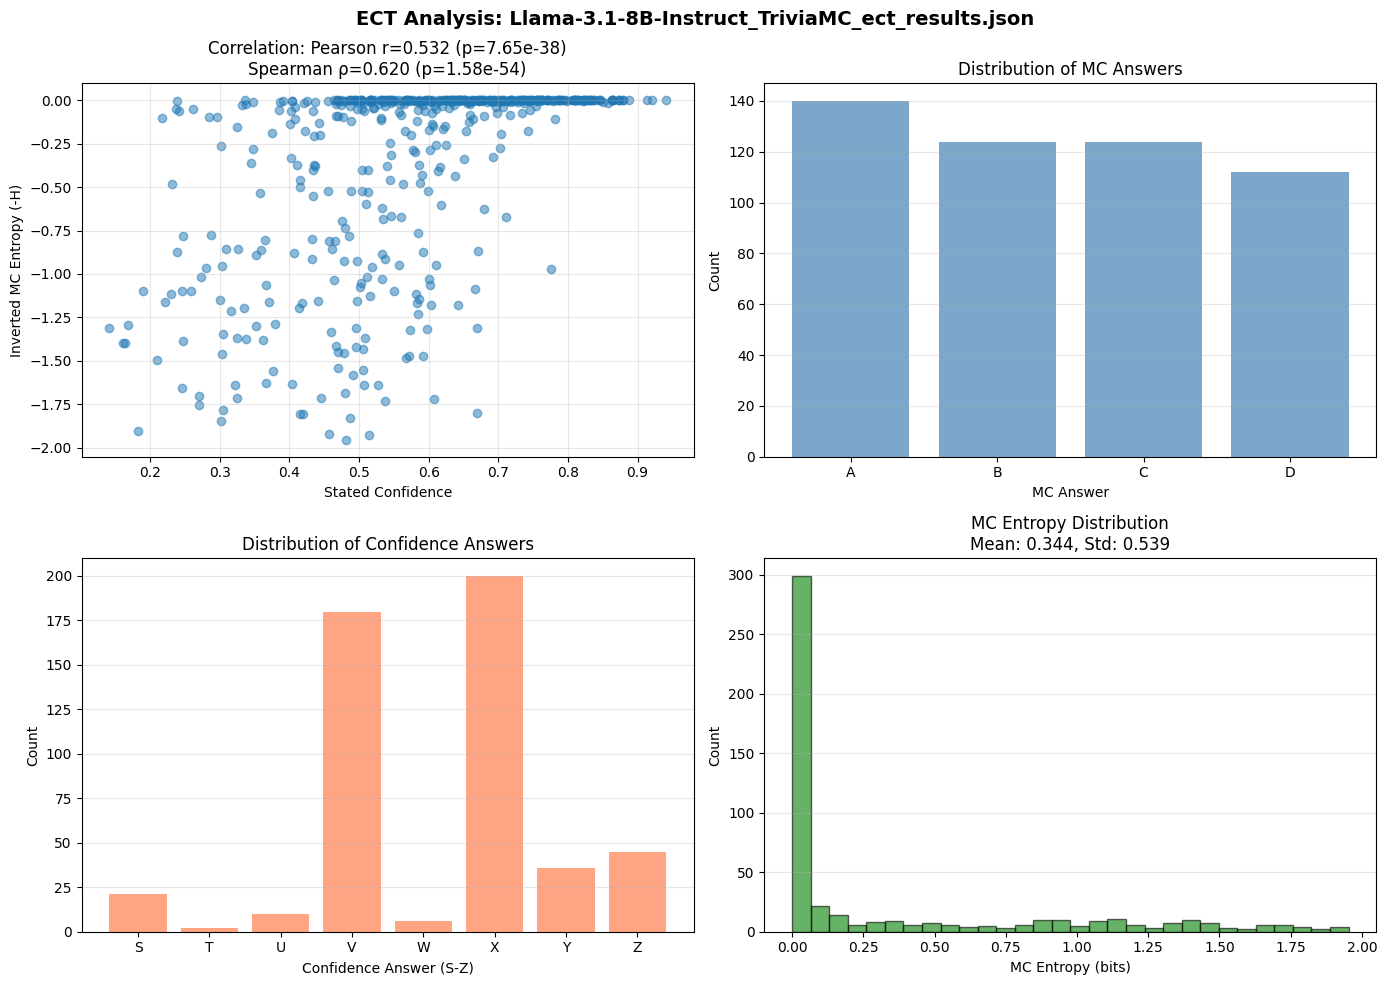


Creating plot for: Llama-3.1-8B_TriviaMC_ect_results.json


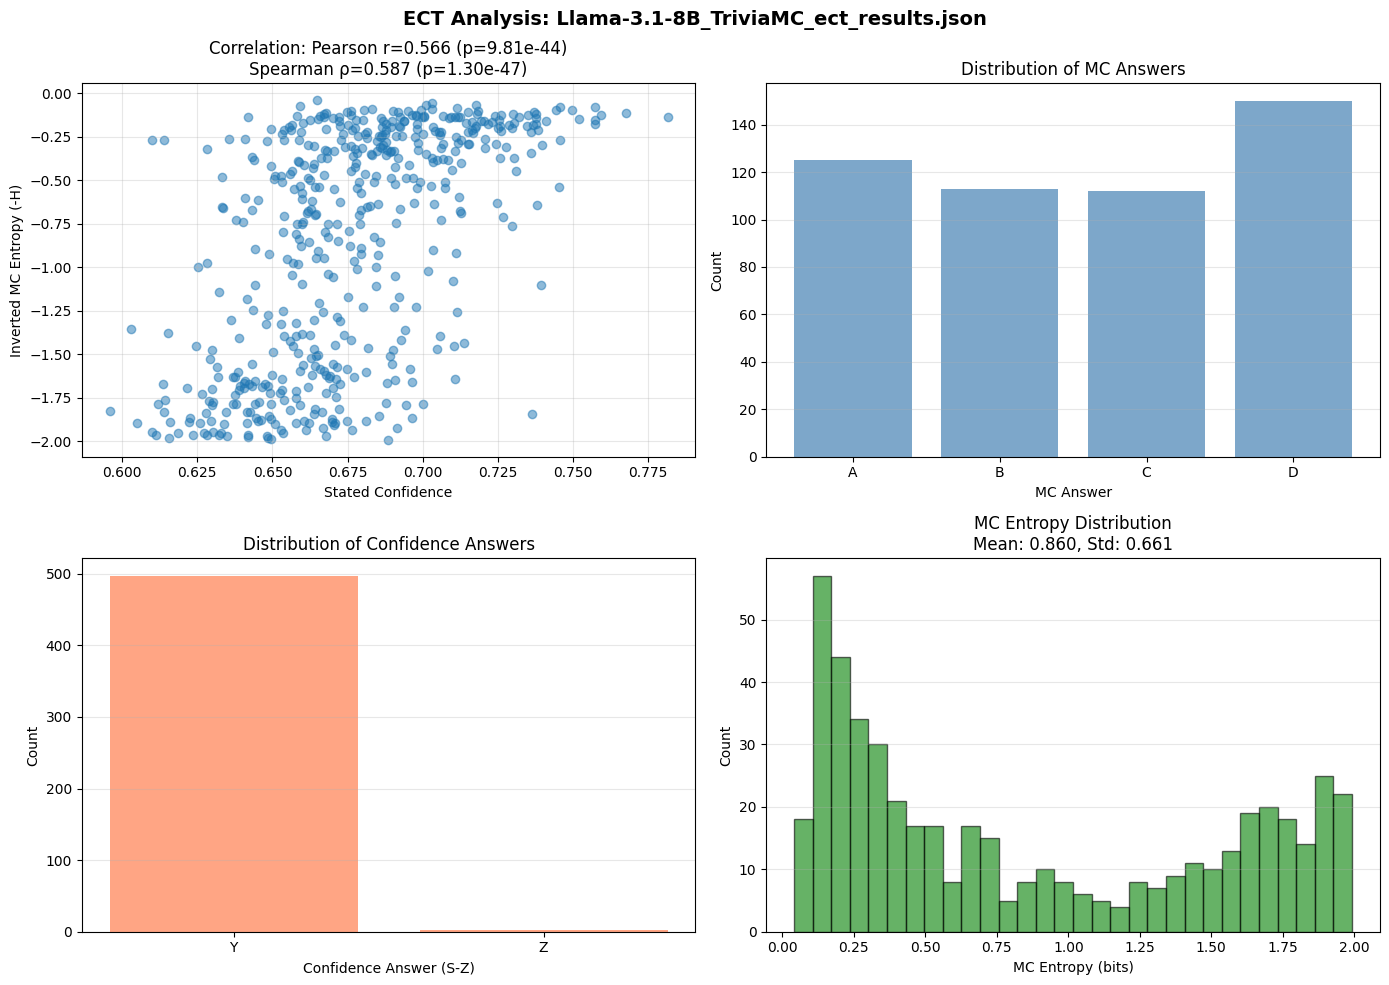


Creating plot for: Llama-3.1-8B_fs-balanced_TriviaMC_ect_results.json


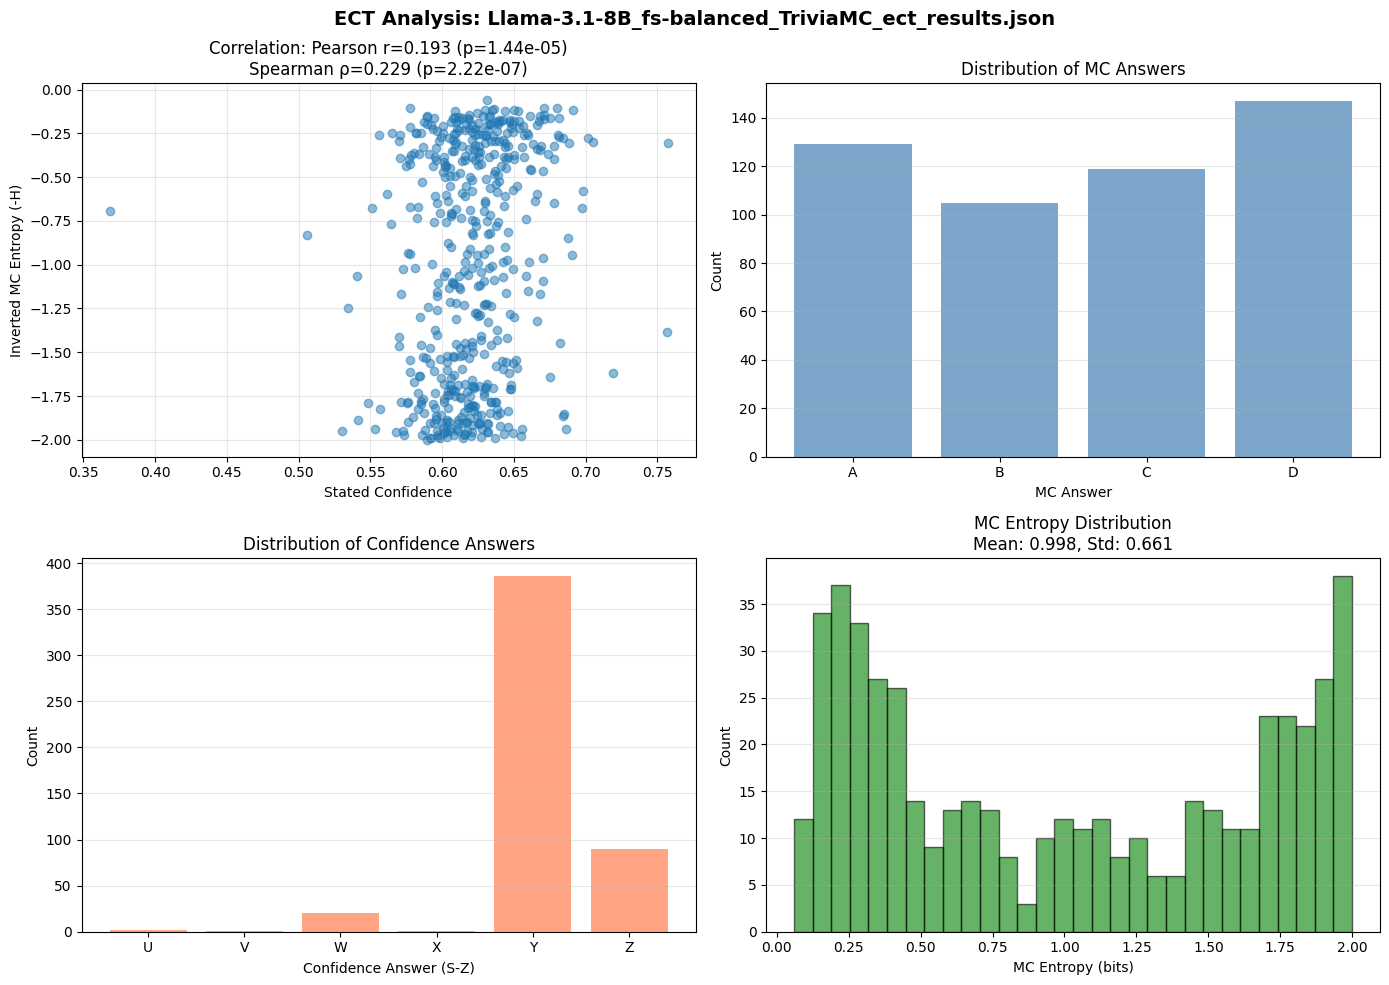


Creating plot for: Llama-3.1-8B_fs-random_ZVU_TriviaMC_ect_results.json


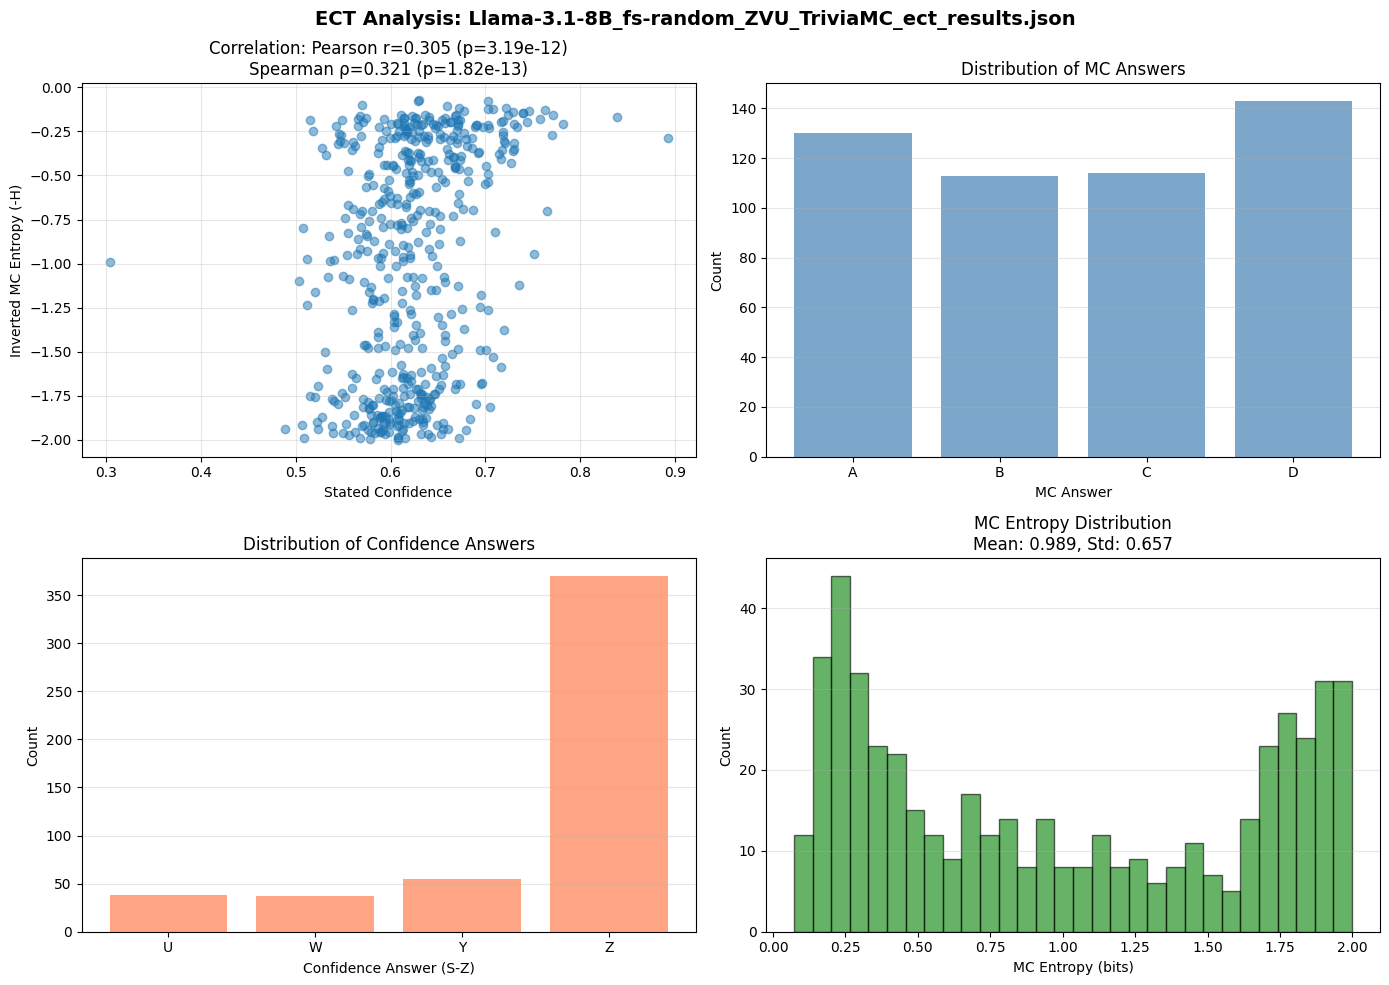


Creating plot for: Llama-3.1-8B_fs-all_answers_Z_TriviaMC_ect_results.json


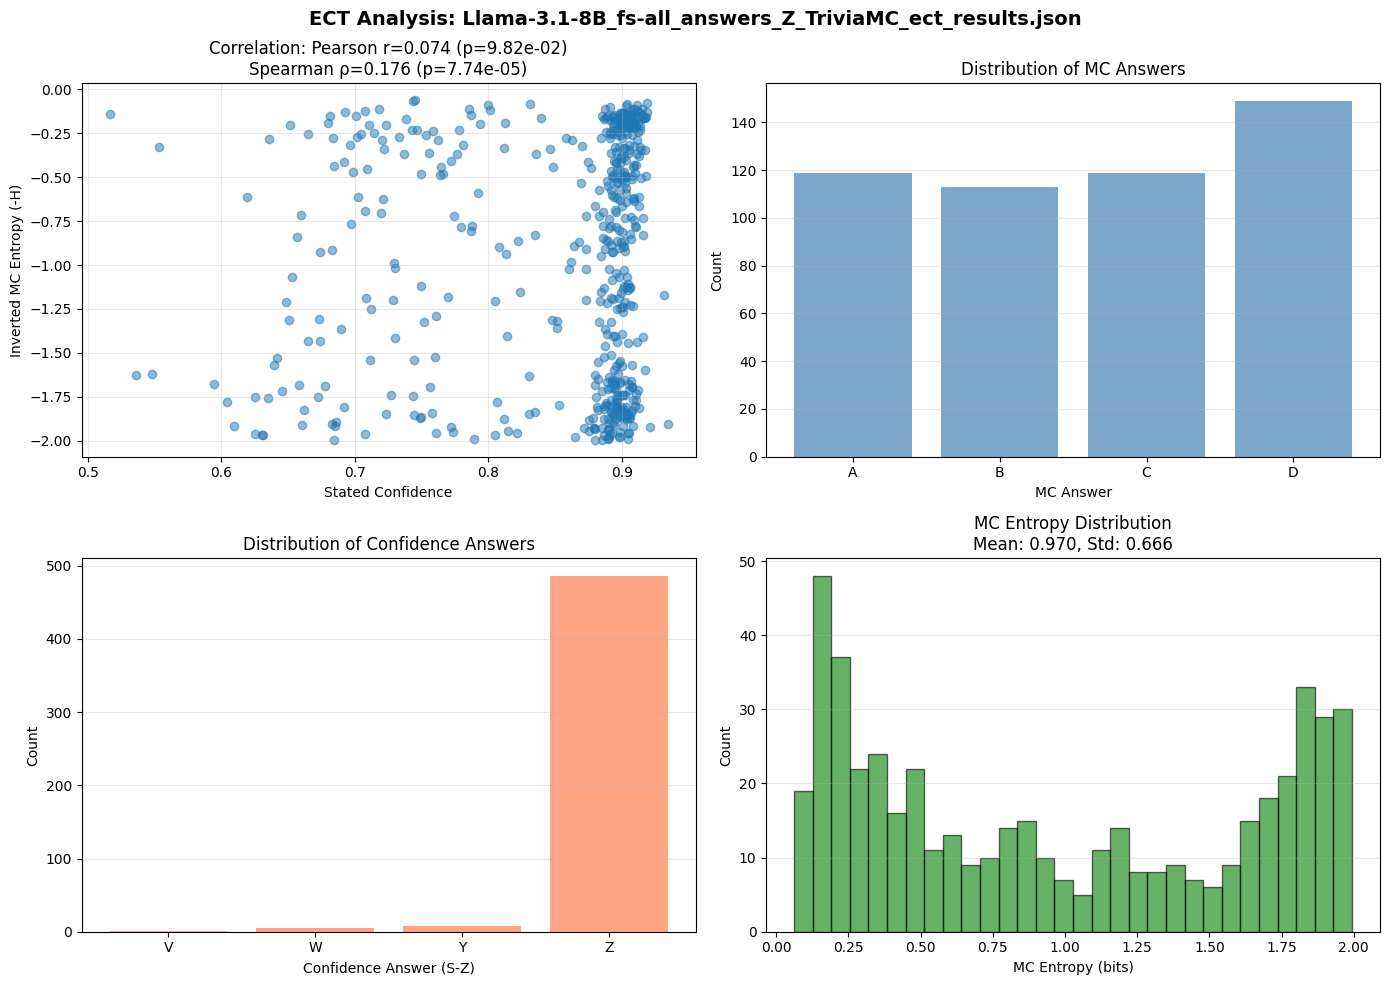


Creating plot for: Llama-3.1-8B_fs-none_TriviaMC_ect_results.json


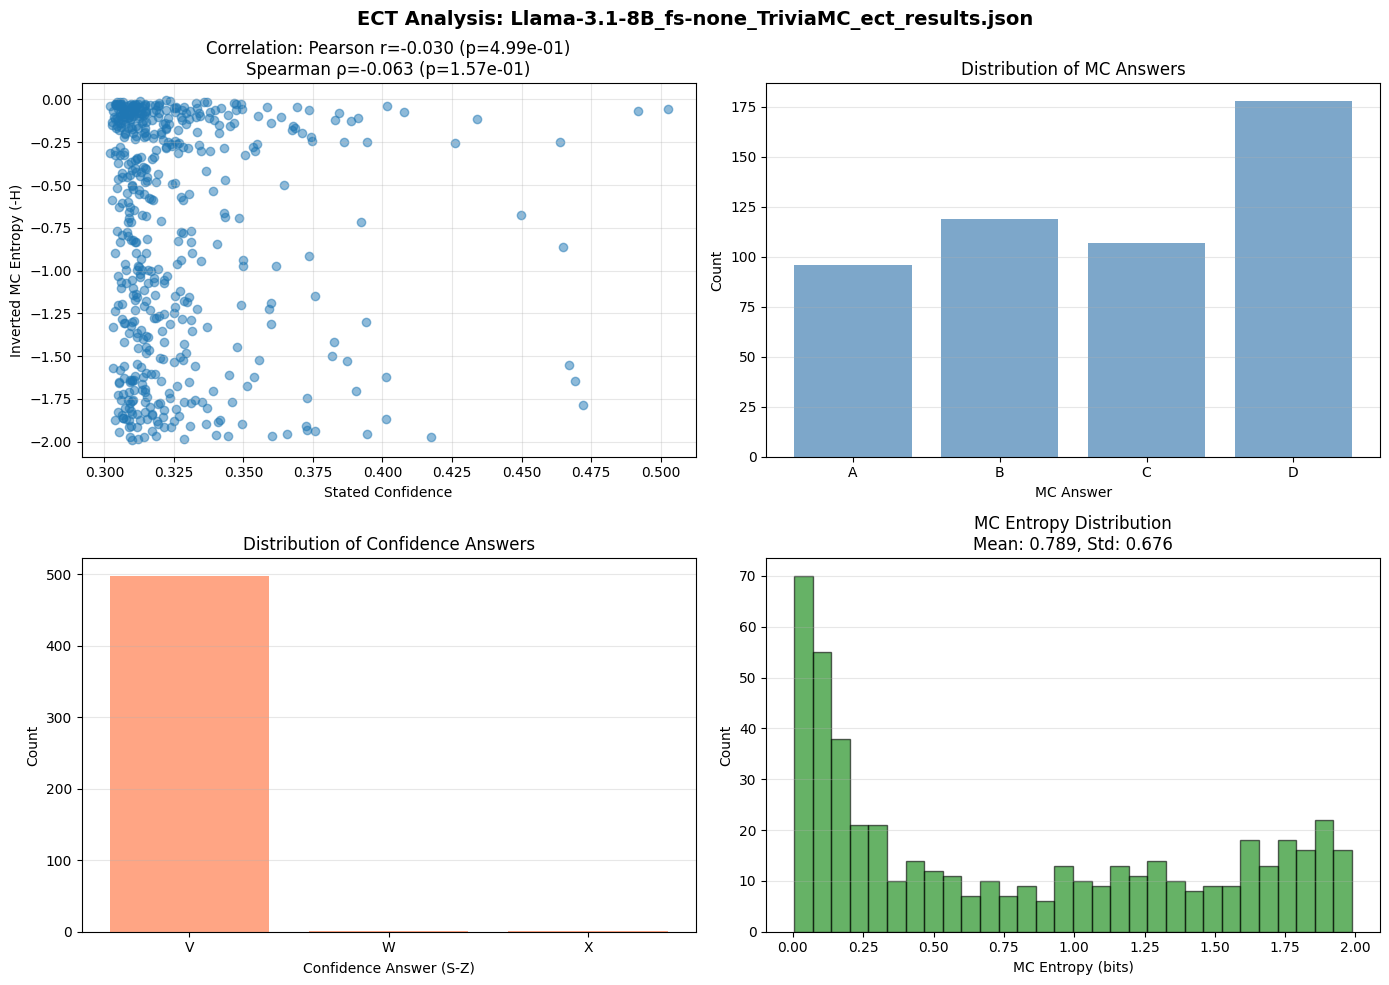


Creating plot for: Llama-3.1-8B_fs-deceptive_examples_TriviaMC_ect_results.json


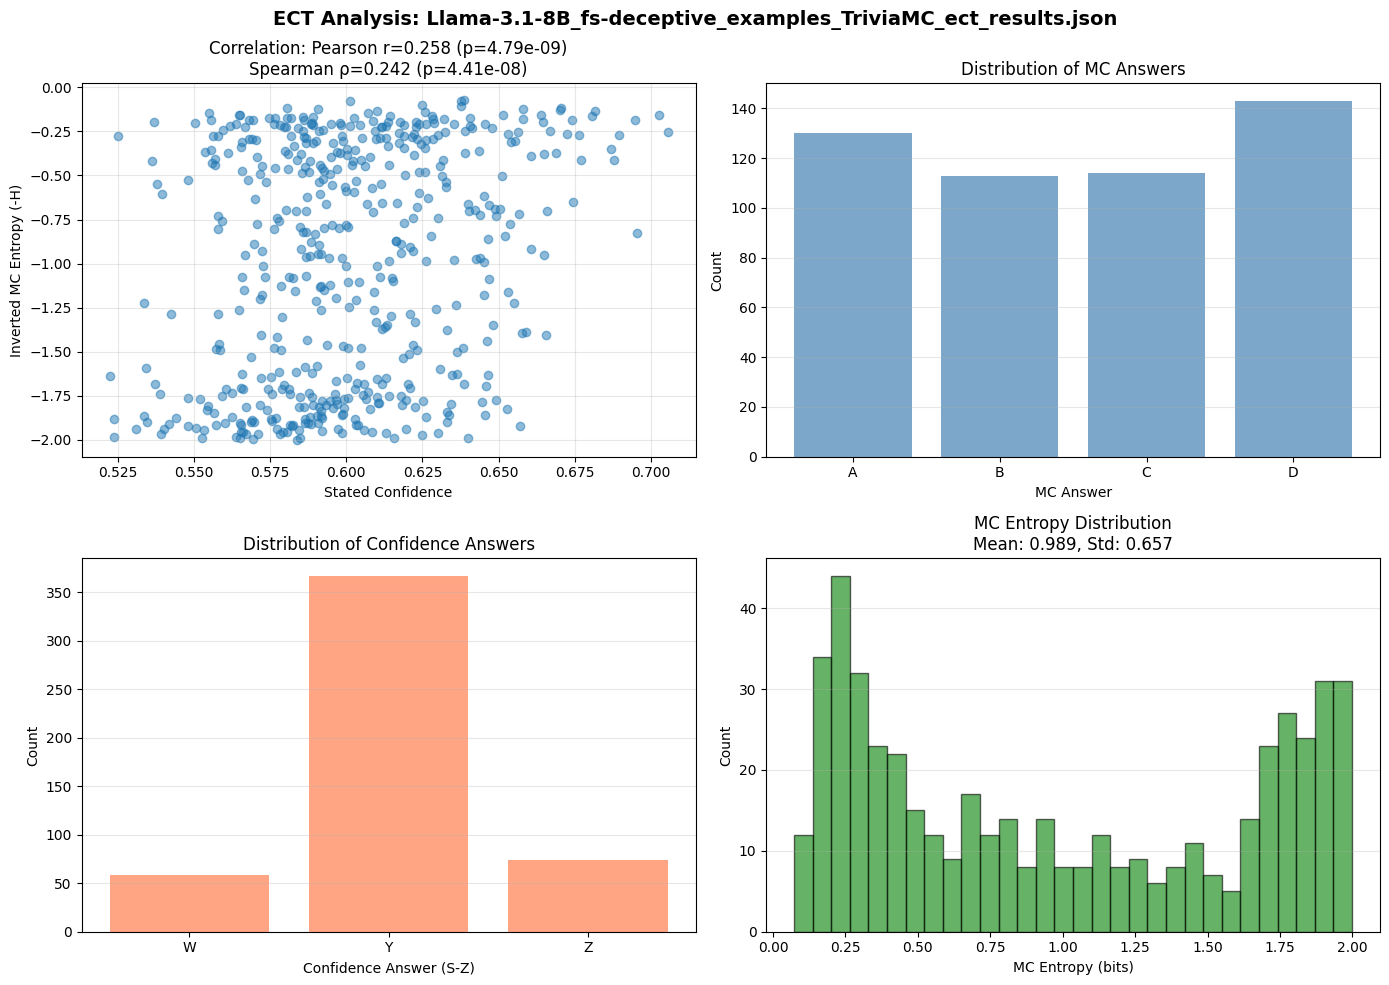


Creating plot for: Llama-3.1-8B-Instruct_adapter-ect_20251222_215412_v0uei7y1_2000_TriviaMC_ect_results.json


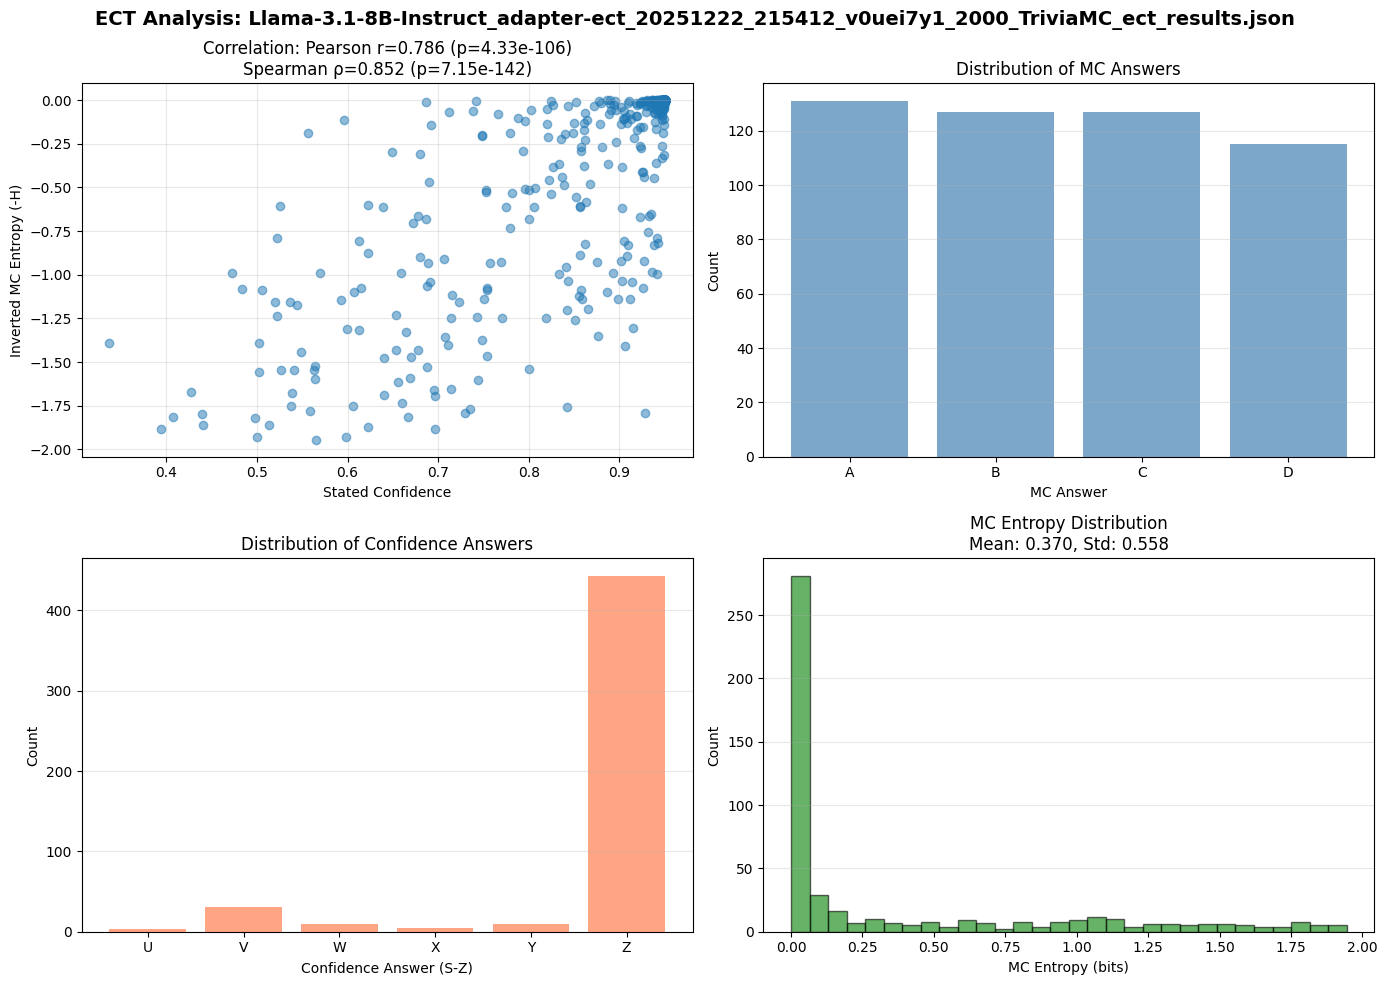

In [5]:
# Create plots for each file
for filepath, results in all_results.items():
    print(f"\nCreating plot for: {Path(filepath).name}")
    fig = plot_analysis(filepath, results)
    plt.show()

In [6]:
# Summary comparison across all files
print("\n" + "="*80)
print("SUMMARY COMPARISON")
print("="*80)

summary_data = []
for filepath, results in all_results.items():
    filename = Path(filepath).name
    summary_data.append({
        'file': filename,
        'n': results['n_questions'],
        'pearson_r': results['pearson_r'],
        'spearman_r': results['spearman_r'],
        'mean_entropy': np.mean(results['mc_entropies'])
    })

# Sort by Pearson correlation
summary_data.sort(key=lambda x: x['pearson_r'], reverse=True)

print(f"\n{'File':<70} {'N':>5} {'Pearson r':>10} {'Spearman ρ':>11} {'Mean H':>8}")
print("-"*110)
for item in summary_data:
    print(f"{item['file']:<70} {item['n']:>5} {item['pearson_r']:>10.3f} {item['spearman_r']:>11.3f} {item['mean_entropy']:>8.3f}")


SUMMARY COMPARISON

File                                                                       N  Pearson r  Spearman ρ   Mean H
--------------------------------------------------------------------------------------------------------------
Llama-3.1-8B-Instruct_adapter-ect_20251222_215412_v0uei7y1_2000_TriviaMC_ect_results.json   500      0.786       0.852    0.370
Llama-3.1-8B_TriviaMC_ect_results.json                                   500      0.566       0.587    0.860
Llama-3.1-8B-Instruct_TriviaMC_ect_results.json                          500      0.532       0.620    0.344
Llama-3.1-8B_fs-random_ZVU_TriviaMC_ect_results.json                     500      0.305       0.321    0.989
Llama-3.1-8B_fs-deceptive_examples_TriviaMC_ect_results.json             500      0.258       0.242    0.989
Llama-3.1-8B_fs-balanced_TriviaMC_ect_results.json                       500      0.193       0.229    0.998
Llama-3.1-8B_fs-all_answers_Z_TriviaMC_ect_results.json                  500      0.07